## Imports

In [101]:
import pyfar as pf
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import soundfile as sf

## Helper Functions

In [102]:
def deg2rad(deg):
    return deg * np.pi / 180

def rad2deg(rad):  
    return rad * 180 / np.pi        

## Simple HRTF Distance Extrapolation

In [103]:
# Inverse of the speed of sound in air
delta = 1/343.0
# Initial delay for HUTUBS HRIRs measured at 1.47m radius
measured_radius = 1.5
initial_delay = measured_radius * delta
# Sampling rate
sr = 44100

def distance_delay(sr, ir, distance):
    # Delays impulse response for the given distance
    delay = distance * delta
    delay_gap = delay - initial_delay
    delay_samples = int(abs(delay_gap) * sr)
    if delay_gap > 0:
        # Add zeros to the beginning of the impulse response
        ir = np.pad(ir, (delay_samples, 0), 'constant')
    elif delay_gap < 0 and delay_samples < len(ir):
        # Remove zeros from the beginning of the impulse response
        ir = ir[delay_samples:]
    return ir

def distance_gain(ir, distance):
    # Scales impulse response for the given distance
    g = measured_radius / distance
    return g * ir

def distance_ir(sr, ir, distance):
    # Delays and scales impulse response for the given distance
    ir = distance_delay(sr, ir, distance)
    ir = distance_gain(ir, distance)
    return ir

## Pyfar HRIR Convolution

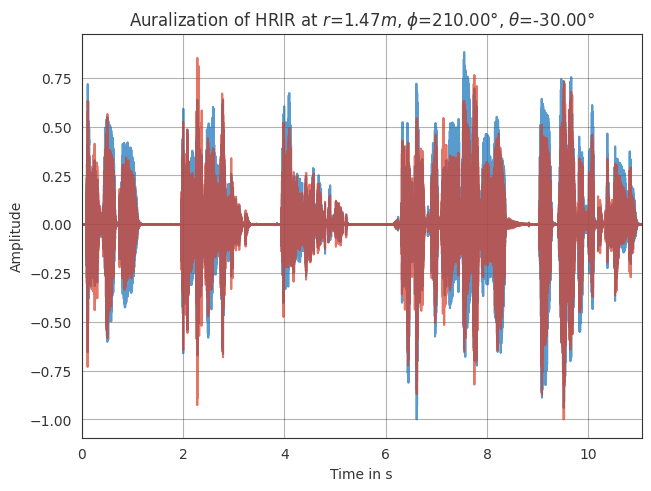

In [112]:
hrirs, sources, _ = pf.io.read_sofa(os.path.join('..', 'assets', 'pp1_HRIRs_measured.sofa'))

signal, sr = librosa.load(os.path.join('..', 'tests', 'input.wav'), sr=44100, mono=False)

idx = 331
hrir = hrirs[idx]
source = sources[idx]
radius, azimuth, elevation = *source.radius, *source.azimuth, *source.elevation

signal = pf.Signal(signal, sr)
auralization = pf.dsp.convolve(hrir, signal)
auralization = pf.dsp.normalize(auralization)

sf.write(os.path.join('..', 'tests', 'output', f'auralization_pp1_HRIRs_measured_{idx}.wav'), auralization.time.T, sr)

ax = pf.plot.time(auralization, label='convolved')
for line in ax.lines: line.set_alpha(0.7)
ax.set_title(fr'Auralization of HRIR at $r$={radius:.2f}$m$, $\phi$={rad2deg(azimuth):.2f}°, $\theta$={(rad2deg(elevation)):.2f}°')
plt.show()